Context

##### One of the three major crops – rice, wheat and maize – rice is by far the most important food crop for people in low- and lower-middle-income countries. Although rich and poor people alike eat rice in low-income countries, the poorest people consume relatively little wheat and are therefore deeply affected by the cost and availability of rice.

In many Asian countries, rice is the fundamental and generally irreplaceable staple, especially of the poor. For the extreme poor in Asia, who live on less than dollar 1.25 a day, rice accounts for nearly half of their food expenditures and a fifth of total household expenditures, on average. This group alone annually spends the equivalent of $62 billion (purchasing power parity) on rice. Rice is critical to food security for many of the world’s poor people.


### Context

This dataset contains 120 jpg images of disease infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.

Classes

*   Leaf smut

*   Brown spot
*  Bacterial leaf blight

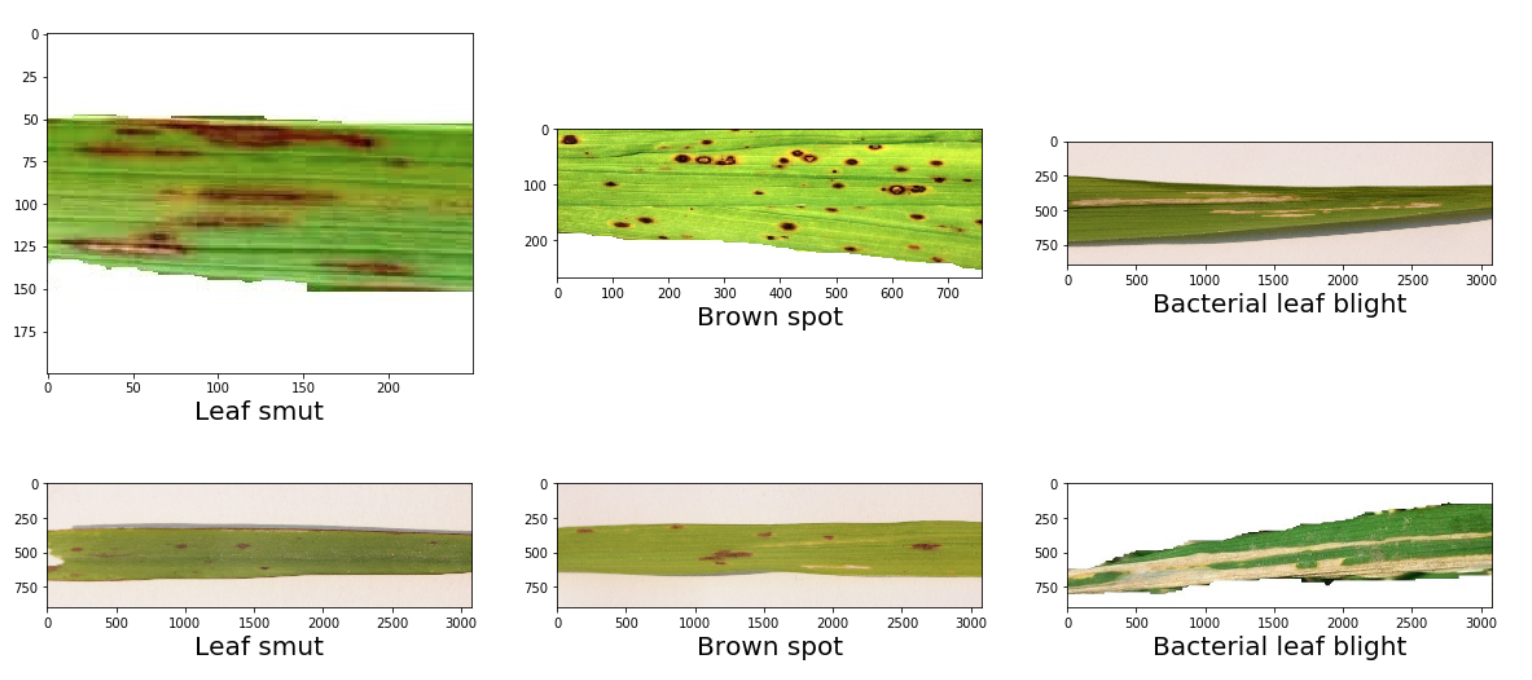

This dataset is associated with the following paper: Detection and Classification of Rice Plant Diseases

#### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import cv2
import os
from PIL import Image
import warnings
import zipfile
import splitfolders
from keras import Sequential
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Activation,MaxPooling2D,Dropout,BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
warnings.filterwarnings('ignore')

# RICE LEAF DISEASE DETECTION USING CNN

### This dataset contains 120 jpg images of disease infected rice leaves. The images are       grouped into 3 classes based on the type of disease. There are 40 images in each class.

### Classes

### Leaf smut
### Brown spot
### Bacterial leaf blight

### Unzipping file 

In [2]:
with zipfile.ZipFile("PRCP-1001-RiceLeaf (1).zip", 'r') as zip_ref:# get the path for rice_leaf.
     # creates new folder 'rice_leaf_final' and saves all images present in rice_leaf Zip.
    zip_ref.extractall("rice_leaf_final")

### Unzipping file inside rice_leaf_final

In [3]:
# Extracting Bacterial_leaf_bright in same folder
with zipfile.ZipFile("rice_leaf_final/Data/Bacterial leaf blight-20200814T055237Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall("rice_leaf_final/Data/Bacterial_leaf_bright")

# Extracting Brown_spot in same folder
with zipfile.ZipFile("rice_leaf_final/Data/Brown spot-20200814T055208Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall("rice_leaf_final/Data/Brown_spot")

# Extracting leaf_smut in same folder
with zipfile.ZipFile("rice_leaf_final/Data/Leaf smut-20200814T055530Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall("rice_leaf_final/Data/leaf_smut")

### Deleting zip file

In [4]:
os.remove("rice_leaf_final/Data/Leaf smut-20200814T055530Z-001.zip")
os.remove("rice_leaf_final/Data/Brown spot-20200814T055208Z-001.zip")
os.remove("rice_leaf_final/Data/Bacterial leaf blight-20200814T055237Z-001.zip")

### Splitting Folder in Test, Validation and Training dataset

Here we are splitting the data into train, validation and test dataset in the ratio of (80,10,10) inorder to train , validate and test our model.

In [5]:
splitfolders.ratio(r"rice_leaf/Data", output="output_final", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 119 files [00:03, 37.66 files/s]


In [9]:
# Sorting the path of data into variable
train_dir = 'output_final/train'  #Location of training images
validation_dir = 'output_final/val' # Location of validation images
test_dir ='output_final/test' # Location of test images

### Preproceesing the traing and validation dataset- Image transform

ImageDataGenerator class allows the users to perform image augmentation while training the model.Its allows us to randomly rotate the images through any degree between 0 to 360 by providing an integer valuein the rotation_range augument.

In [10]:
# Generating batches of image data- Rescaling, shifting and transforming data
train_datagen = ImageDataGenerator(
    rescale= (1./255),
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=(1./255))

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180,180),
    batch_size=15,
    color_mode='rgb',
    class_mode='categorical',shuffle=True)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(180,180),
    batch_size=15,
    color_mode='rgb',
    class_mode='categorical',shuffle=True)

Found 95 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


## PLOTTING TRAIN IMAGES WITH THEIR LABELS


In [11]:
# plotting train images with their labels
def plots(ims, figsize=(20,25), rows=4, interp = False, title = None):
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows if len(ims) % 2 ==0 else len(ims) // rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        sp.set_title(class_names[title[i].tolist().index(1)],fontsize=16)
        plt.imshow(ims[i])

# Make list of classes
class_names = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

Plotting train image with their label


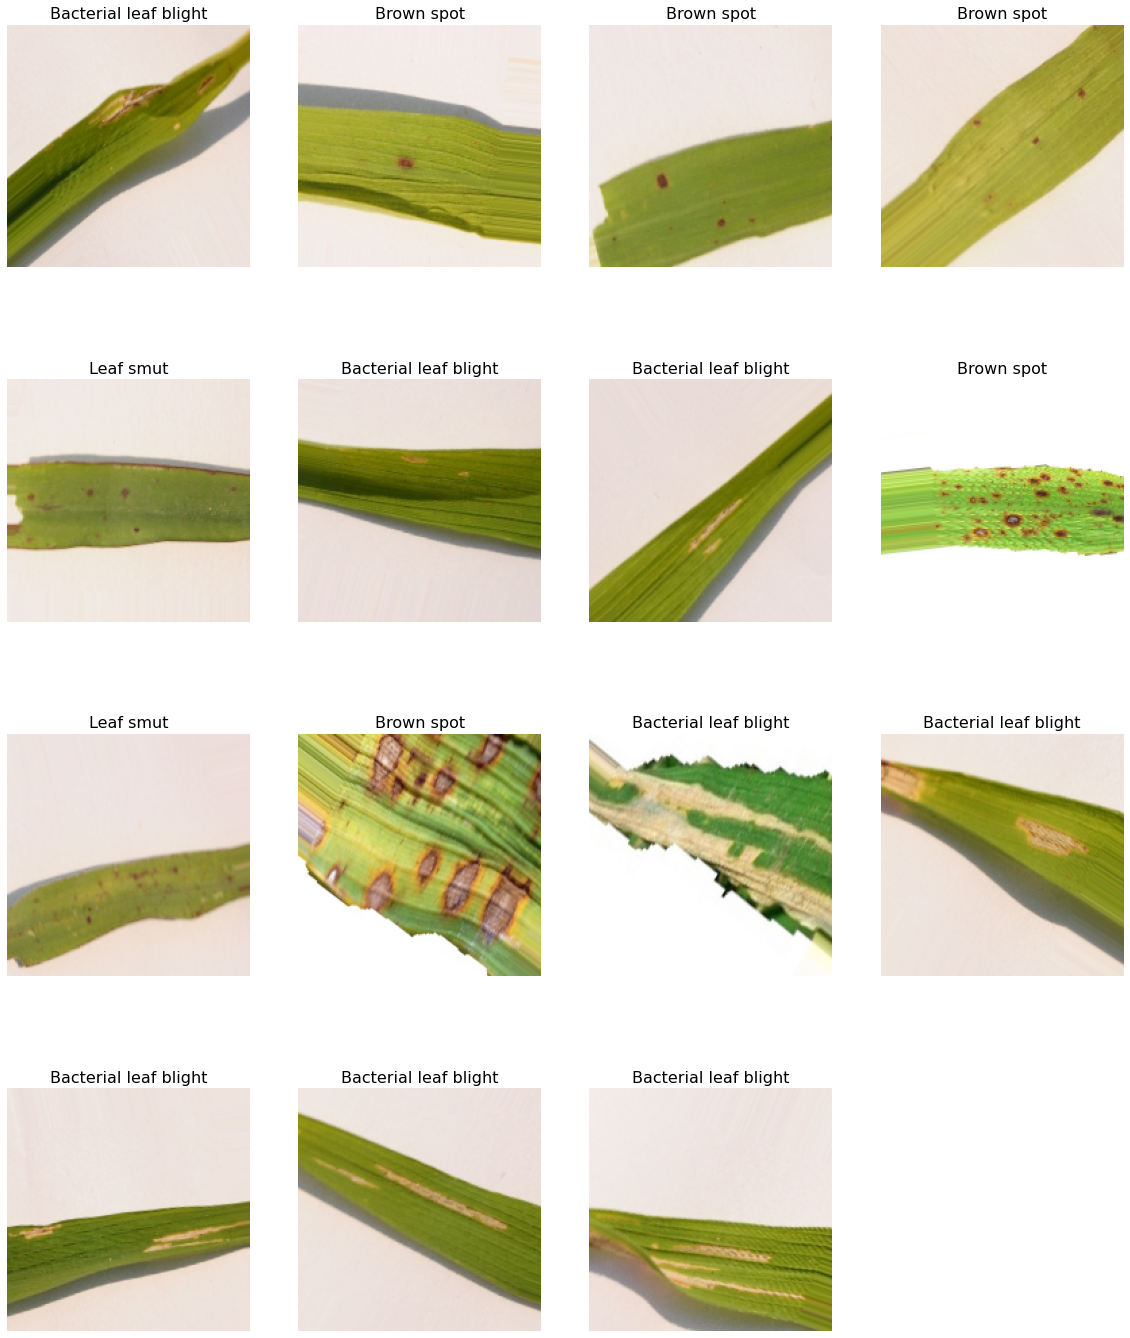

In [12]:
print("Plotting train image with their label")
imgs, labels = next(train_generator)
plots(imgs, title = labels)

## Building the CNN

Before building CNN lets knw abt it:

  A convolutional neural network, or CNN, is a deep learning neural network sketched for processing structured arrays of data such as portrayals.CNN are very satisfactory at picking up on design in the input image, such as lines, gradients, circles, or even eyes and faces.This characteristic that makes convolutional neural network so robust for computer vision.
CNN can run directly on a underdone image and do not need any preprocessing.
A convolutional neural network is a feed forward neural network, seldom with up to 20.
The strength of a convolutional neural network comes from a particular kind of layer called the convolutional layer.
CNN contains many convolutional layers assembled on top of each other, each one competent of recognizing more sophisticated shapes.
With three or four convolutional layers it is viable to recognize handwritten digits and with 25 layers it is possible to differentiate human faces.
The agenda for this sphere is to activate machines to view the world as humans do, perceive it in a alike fashion and even use the knowledge for a multitude of duty such as image and video recognition, image inspection and classification, media recreation, recommendation systems, natural language processing, etc.

### Convolutional Neural Network Design

The construction of a convolutional neural network is a multi-layered feed-forward neural network, made by assembling many unseen layers on top of each other in a particular order.
It is the sequential design that give permission to CNN to learn hierarchical attributes.
In CNN, some of them followed by grouping layers and hidden layers are typically convolutional layers followed by activation layers.
The pre-processing needed in a ConvNet is kindred to that of the related pattern of neurons in the human brain and was motivated by the organization of the Visual Cortex.

In [13]:
tf.random.set_seed(32) # setting Random generating seed value

In [14]:
# initialising the CNN
cnn = tf.keras.models.Sequential()

In [15]:
# Convolution
cnn.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(180,180,3),padding='same',activation='relu'))

In [16]:
# Pooling
cnn.add(MaxPool2D(pool_size=(2,2),strides=2))

## Adding a Second Convolutional Layer

In [17]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))

## Adding a Third Convolutional Layer

In [18]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))

In [19]:
# Flatteting-pooled feature maps into a single long continuous linear vector
cnn.add(tf.keras.layers.Flatten())

In [20]:
# input layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

In [21]:
# Output Layer
cnn.add(tf.keras.layers.Dense(units=3, activation='softmax'))

### Summary of model CNN

In [22]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 32)       0

In [23]:
# Compling the model CNN
cnn.compile(optimizer = 'adam', loss = 'CategoricalCrossentropy', metrics = ['accuracy'])

Callback to save the Keras model or model weights at some frequency. ModelCheckpoint callback is used in conjunction with training using model.fit () to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

### Training the CNN on the Training set and evaluating it on the validation dataset

In [28]:
# Fitting the data
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras", # path to save the model file
        save_best_only=True,
        monitor="val_loss")
]
    
history = cnn.fit_generator(train_generator,
    epochs=90, # epochs used to how many itertion (1fp + loss + 1bp)
    validation_data = val_generator,shuffle=True
)

Epoch 1/90
7/7 [==============================] - 7s 968ms/step - loss: 0.1466 - accuracy: 0.9368 - val_loss: 0.7402 - val_accuracy: 0.9091
Epoch 2/90
7/7 [==============================] - 7s 1s/step - loss: 0.0941 - accuracy: 0.9789 - val_loss: 0.9630 - val_accuracy: 0.7273
Epoch 3/90
7/7 [==============================] - 7s 1s/step - loss: 0.1324 - accuracy: 0.9474 - val_loss: 0.2576 - val_accuracy: 0.9091
Epoch 4/90
7/7 [==============================] - 7s 954ms/step - loss: 0.1554 - accuracy: 0.9053 - val_loss: 0.7867 - val_accuracy: 0.7273
Epoch 5/90
7/7 [==============================] - 7s 912ms/step - loss: 0.1184 - accuracy: 0.9684 - val_loss: 0.7711 - val_accuracy: 0.7273
Epoch 6/90
7/7 [==============================] - 7s 956ms/step - loss: 0.1116 - accuracy: 0.9368 - val_loss: 0.7269 - val_accuracy: 0.8182
Epoch 7/90
7/7 [==============================] - 7s 1s/step - loss: 0.1043 - accuracy: 0.9579 - val_loss: 0.7171 - val_accuracy: 0.7273
Epoch 8/90
7/7 [=============

### After Training
#### Validation Accuracy-96%
#### Training Accuracy- 90%

#### Model Saving

In [29]:
cnn.save("cnn.h5")

## PLOTTING THE TRAINING ACCURACY AND VALIDATION ACCURACY AND TRAINING LOSS AND VALIDATION LOSS

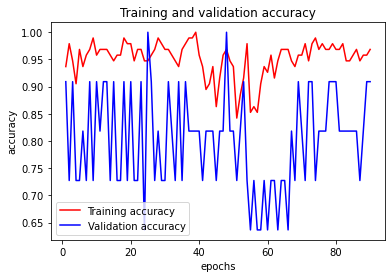

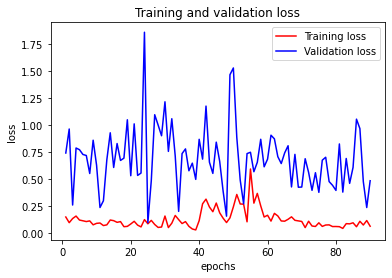

In [30]:
# Step:9 Plotting the training accuracy and validation accuracy
# Plotting the traning loss and validation loss
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

## EVALUATION AND TESTING MODEL

In [31]:
test_datagen = ImageDataGenerator(rescale=(1./255))

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180,180),
    batch_size=15,
    color_mode='rgb',
    class_mode='categorical')

Found 13 images belonging to 3 classes.


In [32]:
cnn.evaluate(test_generator)

1/1 [==============================] - 1s 562ms/step - loss: 0.8263 - accuracy: 0.8462


[0.8263478875160217, 0.8461538553237915]

## * Here the loss is 0.82 and the accuracy of the model is 84.62

## VISUALISE THE PREDICTION OF MODEL

1/1 [==============================] - 0s 41ms/step


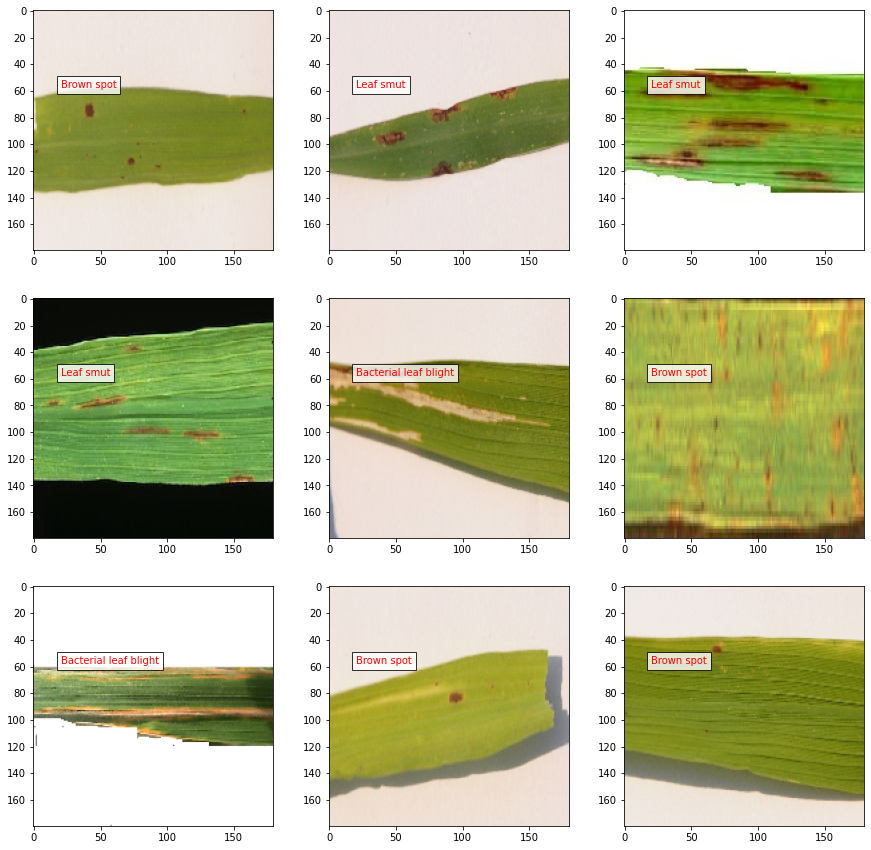

In [33]:
# Visualise the prediction of the model
imgs, labels = next(test_generator)
fig =plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img_t = np.expand_dims(imgs[i],axis=0)
    prediction = cnn.predict(img_t)
    idx = prediction[0].tolist().index(max(prediction[0]))
    plt.text(20,58, class_names[idx],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(imgs[i])

## Making a Single prediction

In [34]:
from keras.preprocessing import image

In [37]:
test_image =tf.keras.utils.load_img('E:\\Datamites internship project\\Rice-leaf\\output_final\\test\\leaf_smut\\DSC_0318.jpg', target_size = (180,180))
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train_generator.class_indices
if result[0][0] == 1:
  prediction = 'Bacterial leaf Bright'
elif result[0][1]==1:
  prediction = 'Brown-smut'
else:
    prediction="leaf_smut"

1/1 [==============================] - 0s 36ms/step


In [38]:
print(prediction)

leaf_smut


### Conclusion

In this project "RICE LEAF DISEASE DECTION" we have selected the Convolutional Neural Network (CNN or ConvNet) because ,it is a subtype of Neural Networks that is mainly used for applications in image and speech recognition. Its built-in convolutional layer reduces the high dimensionality of images without losing its information. That is why CNNs are especially suited for this use case.
After applying CNN model we tested our model on test dataset and validation dataset  where we found that our model is able to predict correctly with an accuracy of  
